In [288]:
import cv2
from matplotlib import pyplot as plt
from pigeon import annotate
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F
from torchvision.models import resnet34

In [15]:
%matplotlib inline

In [128]:
# Saving on disk frames
vidcap = cv2.VideoCapture('ars_che.mp4')
success,image = vidcap.read()
count = 0
batch = 24
n_batches = 5
columns = 3
rows = 2
loop_n = 0
skip = 24 # How much frames to skip
!rm -rf frames
!mkdir frames

loop number = 8


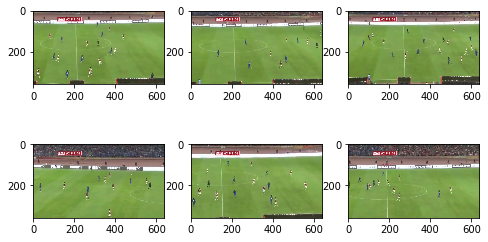

In [143]:
print('loop number = {}'.format(loop_n))
fig=plt.figure(figsize=(8, 4.5))
while success and (count%(n_batches*batch) != 0 or count == n_batches*batch*loop_n):
    cv2.imwrite("frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
    if count%batch == 0:
        fig.add_subplot(rows, columns, ((count//batch)%n_batches)+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for i in range(skip):
        vidcap.read()
    success,image = vidcap.read()
    count += 1
from pigeon import annotate
from IPython.display import display, Image
loop_n += 1
fig.add_subplot(rows, columns, 6)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# https://pytorch.org/docs/stable/torchvision/models.html#classification
# Use resnet34 as feature extractor and logreg for classification of frame on two classes:
#           ^(It might to be a good idea to experiment with VGG16(much more GFlops requires))
# (0)Soccer field and (1)not
# Pass it to YOLO v3 for players detection
# Do in parallel Person Re-Identification
# https://paperswithcode.com/sota/person-re-identification-on-market-1501
# https://paperswithcode.com/paper/omni-scale-feature-learning-for-person-re
# https://paperswithcode.com/paper/joint-discriminative-and-generative-learning

# IMPORTANT
# Pose estimation
# https://paperswithcode.com/task/pose-estimation
# https://paperswithcode.com/task/keypoint-detection

In [138]:
!pip install pigeon

pip 19.2.1 from /home/alex/.virtualenvs/ml/lib/python3.7/site-packages/pip (python 3.7)


In [290]:
class DataLoader(object):
    """Loads/saves frames from video clip"""
 
    def __init__(self, video_file, store_dir, prefix):
        self.store_dir = store_dir
        self.prefix = prefix
        self.vidcap = cv2.VideoCapture(video_file)
        self.image = None
        self.frame_index = -1
        self.index = -1
        self.success = True
        self.multiplyers = {
            'frame': 1,
            'sec': 24,
            'min': 24*60
        }
        
    def clear_store_dir(self):
        !rm -rf frames
        !mkdir frames

    def save(self):
        filename = '{}/{}{}.jpg'.format(self.store_dir, self.prefix, self.frame_index)
        cv2.imwrite(filename, self.image)
        return filename
    
    def get_frame_RGB(self, frame_number):
        if frame_number < self.frame_index:
            return None
        elif frame_number == self.frame_index:
            return cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        while frame_number < self.frame_index-1:
            self.vidcap.read()
            self.frame_index += 1
        self.success, self.image = self.vidcap.read()
        return cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
            
    
    def get_next_RGB(self, skip=0, multiplyer='frame', batch=16, save=True):
        images = []
        filenames = []
        for i in range(batch):
            self.success, self.image = self.vidcap.read()
            if not self.success:
                break
            self.index += 1
            self.frame_index += 1
            images.append(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            if save: 
                filenames.append(self.save())
            if skip > 0:
                skip_frames = skip * self.multiplyers[multiplyer]
                for j in range(skip_frames):
                    self.vidcap.read()
                self.frame_index += skip_frames
        return images, filenames

    def get_indexes(self):
        if self.index == 0:
            return 0, 0
        return (self.index, self.frame_index)
    
    def get_time(self):
        if self.index == 0:
            return '{0} secs, {0} mins'
        return '{} secs, {} mins'.format((self.frame_index%(24*60))//24, self.frame_index//(24*60))
    
    def get_success(self):
        return self.success
    
    def display_image(self):
        if self.image is None:
            return None
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))

In [295]:
data = DataLoader('ars_che.mp4', 'frames', 'frame')

In [296]:
frames_annotation = [['frame_i', 'cl1']]
loop_n = 0
data.clear_store_dir()

In [297]:
print('Loop number = {}'.format(loop_n))
while data.get_success():
#     data.clear_store_dir()
    clear_output(wait=True)
    images, filenames = data.get_next_RGB(skip=6, multiplyer='sec', batch=100)
    # Making Annotation
#     annotations = annotate(
#       filenames,
#       options=['field', 'other'],
#       display_fn=lambda filename: display(Image(filename))
#     )
    loop_n += 1

Loop number = 0


In [282]:
frames_annotation += annotations

In [285]:
pd.DataFrame(frames_annotation[1:], columns=frames_annotation[0]).to_csv('clip_ann.csv')

Annotating num 1, frame num 14401
Time is 0 secs, 10 mins


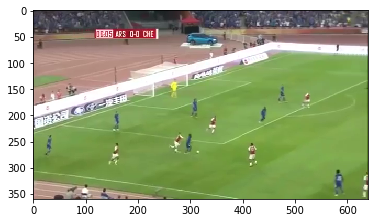

In [140]:
print('Annotating num {}, frame num {}'.format(*data.get_indexes()))
print('Time is {}'.format(data.get_time()))
data.get_next_RGB(5, 'min')
data.display_image()

In [115]:
# Work with image sizes
def resize_to_square(image, size):
    h, w, d = image.shape
    ratio = size / max(h, w)
    resized_image = cv2.resize(image, (int(w*ratio), int(h*ratio)), cv2.INTER_AREA)
    return resized_image

def image_to_tensor(image, normalize=None):
    tensor = torch
        .from_numpy(np.moveaxis(image / (255. if image.dtype == np.uint8 else 1), -1, 0)
        .astype(np.float32))
    if normalize is not None:
        return F.normalize(tensor, **normalize)
    return tensor

def pad(image, min_height, min_width):
    h,w,d = image.shape

    if h < min_height:
        h_pad_top = int((min_height - h) / 2.0)
        h_pad_bottom = min_height - h - h_pad_top
    else:
        h_pad_top = 0
        h_pad_bottom = 0

    if w < min_width:
        w_pad_left = int((min_width - w) / 2.0)
        w_pad_right = min_width - w - w_pad_left
    else:
        w_pad_left = 0
        w_pad_right = 0

    return cv2.copyMakeBorder(
        image, h_pad_top, h_pad_bottom, w_pad_left, w_pad_right, 
        cv2.BORDER_CONSTANT, value=(0,0,0)
    )


class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, size):
        self.df = df
        self.size = size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        image = cv2.imread(row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = resize_to_square(image, self.size)
        image = pad(image, self.size, self.size)
        tensor = image_to_tensor(image, normalize={
            'mean': [0.485, 0.456, 0.406], 
            'std': [0.229, 0.224, 0.225]
        })
            
        return tensor

5

In [137]:
random.seed(70)

0